In [1]:
import os
EXAMPLE_DIR = os.getcwd()
os.chdir(os.path.join('..', '..'))
PROJECT_DIR = os.getcwd()
print('EXAMPLE_DIR: ', EXAMPLE_DIR)
print('PROJECT_DIR: ', PROJECT_DIR)

EXAMPLE_DIR:  /home/karan/Documents/research/regret_syn_toolbox/regret_synthesis_toolbox/examples/CorridorToChargingStation
PROJECT_DIR:  /home/karan/Documents/research/regret_syn_toolbox/regret_synthesis_toolbox


In [2]:
%load_ext autoreload
%autoreload 2
import gym
from IPython.display import Video, display

import sys
import time
import numpy as np
from pathlib import Path

sys.path.append(os.path.join(PROJECT_DIR, 'src'))
from src.graph import Graph
from src.graph import graph_factory
from src.config import ROOT_PATH
from src.strategy_synthesis.multiobjective_solver import MultiObjectiveSolver
from src.simulation.simulator import Simulator

# TODO: Install Wombats to your local directory relative to regret_synthesis_toolbox
WOMBATS_EXPERIMENT_DIRECTORY = os.path.join(os.path.dirname(PROJECT_DIR), 'wombats_experiments')
sys.path.append(WOMBATS_EXPERIMENT_DIRECTORY)
from wombats.systems.minigrid import GYM_MONITOR_LOG_DIR_NAME
from wombats.systems.minigrid import DynamicMinigrid2PGameWrapper, MultiAgentMiniGridEnv

DIR = EXAMPLE_DIR
Graph.graph_dir = DIR

In [3]:
debug = True

env_id = 'MiniGrid-CorridorLava-v0'
pdfa_config_yaml="config/PDFA_charging_station"
player_steps = {'sys': [1], 'env': [1]}
# player_steps = {'sys': [1, 2], 'env': [1]}
player_steps = {'sys': [1, 3], 'env': [1]}

load_game_from_file = False
plot_minigrid = False
plot_pdfa = True
plot_product = False
finite = True
view = True
save_flag = True
format = 'png'

stochastic = False
adversarial = True
plot_strategies=False
plot_graph_with_strategy = False
plot_graph_with_pareto = False
plot_pareto = True
speedup = True

env_filename = os.path.join(DIR, 'plots', 'gym_env.png')
Path(os.path.split(env_filename)[0]).mkdir(parents=True, exist_ok=True)
env_dpi = 300

/home/karan/Documents/research/regret_syn_toolbox/regret_synthesis_toolbox/examples/CorridorToChargingStation/plots/pdfa.png


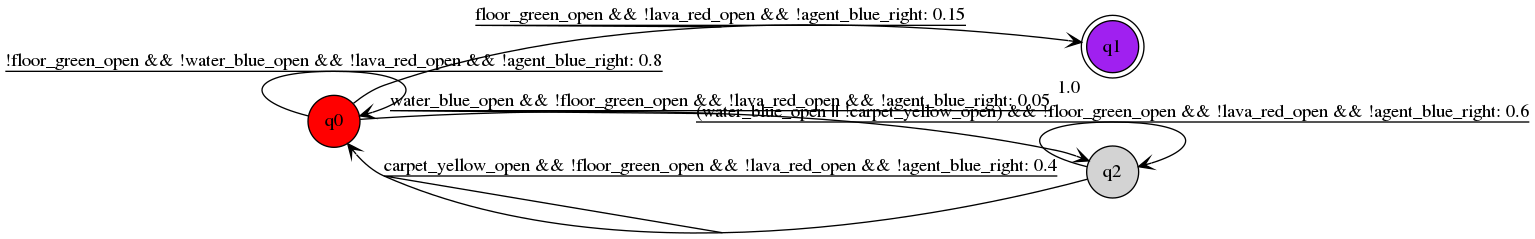

In [4]:
# PDFA
pdfa = graph_factory.get(
    'PDFA',
    graph_name="pdfa",
    config_yaml=pdfa_config_yaml,
    save_flag=save_flag,
    plot=plot_pdfa,
    view=view,
    format=format)

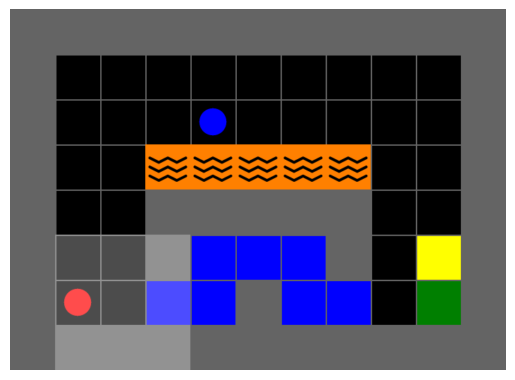

In [5]:

# OpenAI Minigrid Env
env = gym.make(env_id)
env = DynamicMinigrid2PGameWrapper(
        env,
        player_steps=player_steps,
        monitor_log_location=os.path.join(DIR, GYM_MONITOR_LOG_DIR_NAME))
env.reset()
env.render_notebook(env_filename, env_dpi)

In [6]:
file_name = env_id + 'Game'
filepath = os.path.join(DIR, 'config', file_name)
config_yaml = os.path.relpath(filepath, ROOT_PATH)

# Game Construction
start = time.time()
two_player_graph = graph_factory.get('TwoPlayerGraph',
                            graph_name='TwoPlayerGame',
                            config_yaml=config_yaml,
                            from_file=load_game_from_file,
                            minigrid=env,
                            save_flag=save_flag,
                            plot=plot_minigrid,
                            view=view,
                            format=format)
end = time.time()

In [7]:
# Product Game Construction
file_name = env_id + 'ProductAutomaton'
# config_yaml = os.path.join(DIR, 'config', file_name)
config_yaml = None

start = time.time()
game = graph_factory.get('ProductGraph',
    graph_name='ProductAutomaton',
    config_yaml=config_yaml,
    trans_sys=two_player_graph,
    automaton=pdfa,
    save_flag=True,
    prune=False,
    debug=False,
    absorbing=True,
    finite=finite,
    plot=plot_product,
    integrate_accepting=True,
    pdfa_compose=True,
    view=view,
    format=format)
end = time.time()
print(f'Product Construction took {end-start:.2f} seconds')

TypeError: bad operand type for abs(): 'list'

3245 nodes and 28971 edges
1th Iteration took 7.05 seconds
2th Iteration took 13.93 seconds
3th Iteration took 18.08 seconds
4th Iteration took 26.34 seconds
5th Iteration took 23.26 seconds
6th Iteration took 44.35 seconds
7th Iteration took 26.72 seconds
8th Iteration took 29.97 seconds
9th Iteration took 30.61 seconds
10th Iteration took 29.55 seconds
11th Iteration took 45.10 seconds
12th Iteration took 47.56 seconds
13th Iteration took 46.00 seconds
14th Iteration took 48.50 seconds
15th Iteration took 58.25 seconds
Pareto Points Computation took 499.75 seconds


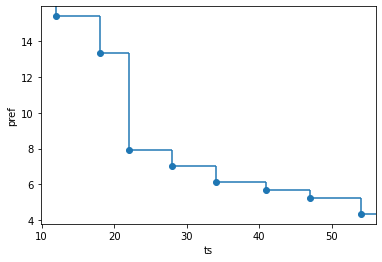

(array([[54.        ,  4.35169905],
        [22.        ,  7.92199587],
        [28.        ,  7.02942167],
        [12.        , 15.3857528 ],
        [34.        ,  6.13684746],
        [41.        ,  5.69056036],
        [18.        , 13.3424503 ],
        [47.        ,  5.24427325]]),
 {(54.0,
   4.351699049342188): <src.prism.strategy.DeterministicStrategy at 0x7fdcb03613d0>,
  (22.0,
   7.9219958703695434): <src.prism.strategy.DeterministicStrategy at 0x7fdcb0302580>,
  (28.0,
   7.029421665112705): <src.prism.strategy.DeterministicStrategy at 0x7fdcb011c2b0>,
  (12.0,
   15.385752799592701): <src.prism.strategy.DeterministicStrategy at 0x7fdcb03026a0>,
  (34.0,
   6.136847459855866): <src.prism.strategy.DeterministicStrategy at 0x7fdcb031a970>,
  (41.0,
   5.690560357227446): <src.prism.strategy.DeterministicStrategy at 0x7fdcbf6e0070>,
  (18.0,
   13.34245030452874): <src.prism.strategy.DeterministicStrategy at 0x7fdcb033a970>,
  (47.0,
   5.244273254599027): <src.prism.strateg

In [8]:
solver = MultiObjectiveSolver(game,
                            epsilon=1e-5,
                            max_iteration=300,
                            stochastic=stochastic,
                            adversarial=adversarial)
solver.solve(plot_strategies=plot_strategies,
                plot_graph_with_strategy=plot_graph_with_strategy,
                plot_graph_with_pareto=plot_graph_with_pareto,
                plot_pareto=plot_pareto,
                speedup=speedup,
                debug=debug,
                view=view,
                format=format)

In [14]:
iterations = 100
iterations = 1

for pp in solver.get_pareto_points():
        strategy = solver.get_a_strategy_for(pp)

        print('-'*100)
        print(f"Evaluate for a pareto point {pp}")
        print('-'*100)

        sim = Simulator(env, game)
        sim.run(iterations=iterations,
                sys_strategy=strategy,
                render=False,
                record_video=iterations<=15)
        sim.get_stats()
        # sim.plot_grid()

----------------------------------------------------------------------------------------------------
Evaluate for a pareto point [54.          4.35169905]
----------------------------------------------------------------------------------------------------
Maximum Costs [54.          4.35169905]
Observation {('floor_green_open',): 1}
----------------------------------------------------------------------------------------------------
Evaluate for a pareto point [22.          7.92199587]
----------------------------------------------------------------------------------------------------
Maximum Costs [22.          7.92199587]
Observation {('floor_green_open',): 1}
----------------------------------------------------------------------------------------------------
Evaluate for a pareto point [28.          7.02942167]
----------------------------------------------------------------------------------------------------
Maximum Costs [28.          7.02942167]
Observation {('floor_green_open',)

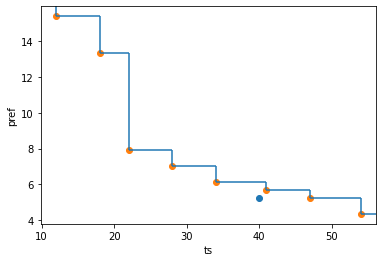

In [10]:
import matplotlib.pyplot as plt
costs = []
for result in sim._results:
    costs.append(result['Cost'])

costs = np.array(costs)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(costs[:, 0], costs[:, 1])

solver.plot_pareto_front(ax)

# Evaluation

In [11]:
# TODO: FIX THIS SHIT

player = 'sys'
SYS_ACTIONS = []
for multiactions in env.player_actions[player]:
    action_strings = []
    for agent, actions in zip(env.unwrapped.agents, multiactions):
        action_string = []
        for action in actions:
            if action is None or np.isnan(action):
                continue
            a_str = agent.ACTION_ENUM_TO_STR[action]
            action_string.append(a_str)
        action_strings.append(tuple(action_string))
    action_strs = action_strings[0] if player == 'sys' else action_strings[1:]
    SYS_ACTIONS.append(tuple(action_strs))

player = 'env'
ENV_ACTIONS = []
for multiactions in env.player_actions[player]:
    action_strings = []
    for agent, actions in zip(env.unwrapped.agents, multiactions):
        action_string = []
        for action in actions:
            if action is None or np.isnan(action):
                continue
            a_str = agent.ACTION_ENUM_TO_STR[action]
            action_string.append(a_str)
        action_strings.append(tuple(action_string))
    action_strs = action_strings[0] if player == 'sys' else action_strings[1:]
    ENV_ACTIONS.append(tuple(action_strs))

print(SYS_ACTIONS)
print(ENV_ACTIONS)

[('north',), ('south',), ('east',), ('west',), ('north', 'north', 'north'), ('north', 'north', 'south'), ('north', 'north', 'east'), ('north', 'north', 'west'), ('north', 'south', 'north'), ('north', 'south', 'south'), ('north', 'south', 'east'), ('north', 'south', 'west'), ('north', 'east', 'north'), ('north', 'east', 'south'), ('north', 'east', 'east'), ('north', 'east', 'west'), ('north', 'west', 'north'), ('north', 'west', 'south'), ('north', 'west', 'east'), ('north', 'west', 'west'), ('south', 'north', 'north'), ('south', 'north', 'south'), ('south', 'north', 'east'), ('south', 'north', 'west'), ('south', 'south', 'north'), ('south', 'south', 'south'), ('south', 'south', 'east'), ('south', 'south', 'west'), ('south', 'east', 'north'), ('south', 'east', 'south'), ('south', 'east', 'east'), ('south', 'east', 'west'), ('south', 'west', 'north'), ('south', 'west', 'south'), ('south', 'west', 'east'), ('south', 'west', 'west'), ('east', 'north', 'north'), ('east', 'north', 'south'), (

In [12]:
pp = solver.get_pareto_points()[0]
strategy = solver.get_a_strategy_for(pp)

# Goes into Water 
sys_actions = [
    SYS_ACTIONS[2], 
    SYS_ACTIONS[2], 
    SYS_ACTIONS[2], 
    SYS_ACTIONS[0], 
    SYS_ACTIONS[2], 
    SYS_ACTIONS[2],
    SYS_ACTIONS[1], 
    SYS_ACTIONS[2], 
    SYS_ACTIONS[2],
    SYS_ACTIONS[0],
    SYS_ACTIONS[0],
    SYS_ACTIONS[0],
    SYS_ACTIONS[2],
    SYS_ACTIONS[1],
    SYS_ACTIONS[1],
    SYS_ACTIONS[1],
    ]

sim = Simulator(env, game)
sim.run_turn_based_game(
    sys_actions=sys_actions,
    # env_actions=env_actions,
    render=False,
    record_video=True)
sim.get_stats()

Maximum Costs [16.         19.47235779]
Observation {('water_blue_open', 'water_blue_open', 'water_blue_open', 'water_blue_open', 'water_blue_open', 'water_blue_open', 'water_blue_open', 'water_blue_open', 'water_blue_open', 'water_blue_open', 'water_blue_open', 'water_blue_open', 'water_blue_open', 'water_blue_open', 'carpet_yellow_open', 'carpet_yellow_open', 'floor_green_open'): 1}


In [13]:
env_actions = [
    ENV_ACTIONS[3], 
    ENV_ACTIONS[1], 
    ENV_ACTIONS[3], 
    ENV_ACTIONS[2], 
    ENV_ACTIONS[2], 
    ENV_ACTIONS[2],
    ENV_ACTIONS[2],
    ENV_ACTIONS[2],
    ENV_ACTIONS[1],
    ENV_ACTIONS[1],
    ENV_ACTIONS[1],
    ENV_ACTIONS[1],
    ENV_ACTIONS[1],
    ENV_ACTIONS[1],
    ENV_ACTIONS[1],
    ENV_ACTIONS[1],
    ]

sim = Simulator(env, game)
sim.run_turn_based_game(
    sys_strategy=strategy,
    env_actions=env_actions,
    render=False,
    record_video=True)
sim.get_stats()

Maximum Costs [54.          4.35169905]
Observation {('floor_green_open',): 1}
